In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import transformers
from transformers import logging as hf_logging
import matplotlib.pyplot as plt
hf_logging.set_verbosity_error()
pd.set_option('display.max_columns',None)
print(f'TF version: {tf.__version__}')
print(f'transformers version: {transformers.__version__}')

TF version: 2.6.4
transformers version: 4.20.1


In [2]:
'''
VERSION: 5
DESC: Deberta v3 base with tensorflow, default CFG
'''
DEBERTA_MODEL="../input/debertav3base"
DATA_PATH="../input/feedback-prize-english-language-learning/"

In [3]:
#Reading data
df_modeling = pd.read_csv(DATA_PATH+"train.csv")
df_sub = pd.read_csv(DATA_PATH+"test.csv")
df_train, df_test = train_test_split(df_modeling,test_size=0.20, random_state=123)

In [4]:
#Useful functions
def inputfromDF(df):
    X = df['full_text']
    Y1 = df['cohesion']
    Y2 = df['syntax']
    Y3 = df['vocabulary']
    Y4 = df['phraseology']
    Y5 = df['grammar']
    Y6 = df['conventions']
    return X, Y1, Y2, Y3, Y4, Y5, Y6

#Roundoff prediction score to nearest multiple of 0.5
def roundoffScore(n):
    x1=math.floor(n)
    if n>x1+0.75:
        return x1+1.0
    elif n>x1+0.25:
        return x1+0.5
    else:
        return x1

#Mean of Root Mean Squared Error of multiple targets
def MCRMSE(y_test, y_pred):
    mse_list=[]
    target_names = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    for i in range(y_test.shape[1]):
        mse_list.append(mean_squared_error(y_test[:,i], y_pred[:,i]))
        print("MSE for {} : {:.4f}".format(target_names[i], mean_squared_error(y_test[:,i], y_pred[:,i])))
    return sum(mse_list)/y_test.shape[1]

def slice_text(string,MAX_LENGTH):
    if len(string)>MAX_LENGTH:
        return string[:(2*MAX_LENGTH)//(3)]+" \n "+string[-(MAX_LENGTH//3):]
    else:
        return string
#Data encoder to tokenize input text for input of deberta
tokenizer = transformers.AutoTokenizer.from_pretrained(DEBERTA_MODEL)
def data_encoder(df,column,tokenizer=tokenizer,MAX_LENGTH=64, return_labels=True):
    text_array=df[column].tolist()
    input_ids, attention_masks = [], []
    for i in text_array:
        token=tokenizer(slice_text(i,MAX_LENGTH),add_special_tokens=True, max_length=MAX_LENGTH, return_attention_mask=True, return_tensors="np", truncation=True, padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_masks.append(token['attention_mask'][0])
    if return_labels:
        labels = np.array(df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]])
        return np.array(input_ids, dtype="int32"), np.array(attention_masks, dtype="int32"), labels
    else:
        return np.array(input_ids, dtype="int32"), np.array(attention_masks, dtype="int32")

#Training tf dataset generator
def get_train_dataset(ids, mask, y):
    x = tf.data.Dataset.from_tensor_slices({"input_ids": tf.constant(ids, dtype="int32"),"attention_mask": tf.constant(mask, dtype="int32")})
    y = tf.data.Dataset.from_tensor_slices((
        tf.constant(y[:, 0], dtype="float32"),
        tf.constant(y[:, 1], dtype='float32'),
        tf.constant(y[:, 2], dtype='float32'),
        tf.constant(y[:, 3], dtype='float32'),
        tf.constant(y[:, 4], dtype='float32'),
        tf.constant(y[:, 5], dtype='float32'),
    ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = tf.data.Dataset.zip((x, y))
    data = data.with_options(options)
    data = data.repeat()#To repear infinitely
    data = data.shuffle(BUFFER_SIZE)#To shuffle entire dataset
    data = data.batch(BATCH_SIZE)#Combine elements into batches
    data = data.prefetch(AUTO)#Number of batch to be ready by CPU when the GPU is processing
    return data

#Validation tf dataset generator
def get_val_dataset(ids, mask, y):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    y = tf.data.Dataset.from_tensor_slices((
        tf.constant(y[:, 0], dtype="float32"),
        tf.constant(y[:, 1], dtype='float32'),
        tf.constant(y[:, 2], dtype='float32'),
        tf.constant(y[:, 3], dtype='float32'),
        tf.constant(y[:, 4], dtype='float32'),
        tf.constant(y[:, 5], dtype='float32'),
    ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = tf.data.Dataset.zip((x, y))
    data = data.with_options(options)
    data = data.repeat()
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Prediction tf dataset generator
def get_pred_dataset(ids, mask):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = x
    data = data.with_options(options)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Meanpool layer required in deberta
class MeanPool(tf.keras.layers.Layer):
    def call(self, x, mask=None):
        broad_mask = tf.cast(tf.expand_dims(mask, -1), "float32")
        x = tf.math.reduce_sum( x * broad_mask, axis=1)
        x = x / tf.math.maximum(tf.reduce_sum(broad_mask, axis=1), tf.constant([1e-9]))
        return x

/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [5]:
#Model building using deberta and Keras Functional API
def build_model(trainable=True):
    input1 = tf.keras.Input(shape=(MAX_LENGTH,), dtype="int32", name="input_ids")
    input2 = tf.keras.Input(shape=(MAX_LENGTH,), dtype="int32", name="attention_mask")
    
    #Setting Dropout layer to 0
    config = transformers.AutoConfig.from_pretrained(DEBERTA_MODEL)
    config.attention_probs_dropout_prob = 0.0
    config.hidden_dropout_prob = 0.0
    
    base_model = transformers.TFAutoModel.from_pretrained(DEBERTA_MODEL, config=config)
    base_model.trainable = trainable
    base_outputs = base_model.deberta({"input_ids": input1,"attention_mask": input2})
    last_hidden_state = base_outputs[0]
    x = MeanPool()(last_hidden_state, mask=input2)
    
    x1 = tf.keras.layers.Dense(units=32, activation='selu',kernel_initializer='lecun_normal')(x)
    x1 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x1)
    output1 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x1)
    
    x2 = tf.keras.layers.Dense(units=32, activation='selu',kernel_initializer='lecun_normal')(x)
    x2 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x2)
    output2 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x2)
    
    x3 = tf.keras.layers.Dense(units=32, activation='selu',kernel_initializer='lecun_normal')(x)
    x3 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x3)
    output3 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x3)
    
    x4 = tf.keras.layers.Dense(units=32, activation='selu',kernel_initializer='lecun_normal')(x)
    x4 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x4)
    output4 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x4)
    
    x5 = tf.keras.layers.Dense(units=32, activation='selu',kernel_initializer='lecun_normal')(x)
    x5 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x5)
    output5 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x5)
    
    x6 = tf.keras.layers.Dense(units=32, activation='selu',kernel_initializer='lecun_normal')(x)
    x6 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x6)
    output6 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x6)
    
    model = tf.keras.Model(inputs={"input_ids": input1,"attention_mask": input2}, outputs= [output1,output2,output3,output4,output5,output6])
    return model

In [6]:
strategy=tf.distribute.MirroredStrategy()
MAX_LENGTH=512
BATCH_SIZE = 16
BUFFER_SIZE = df_train.shape[0]#3200#Size >= df_train shape
AUTO = 1#tf.data.AUTOTUNE#Try 1
steps_per_epoch = df_train.shape[0]//BATCH_SIZE
validation_steps = df_test.shape[0]//BATCH_SIZE

2022-11-12 16:02:28.529370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 16:02:28.530331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 16:02:28.669651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 16:02:28.670502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 16:02:28.671291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
input_train=data_encoder(df_train,'full_text',tokenizer=tokenizer,MAX_LENGTH=MAX_LENGTH,return_labels=True)
input_test=data_encoder(df_test,'full_text',tokenizer=tokenizer,MAX_LENGTH=MAX_LENGTH,return_labels=True)
input_sub=data_encoder(df_sub,'full_text',tokenizer=tokenizer,MAX_LENGTH=MAX_LENGTH,return_labels=False)

In [8]:
train_dataset = get_train_dataset(input_train[0], input_train[1], input_train[2])
test_dataset = get_val_dataset(input_test[0], input_test[1], input_test[2])
test_dataset_wo_label = get_pred_dataset(input_test[0], input_test[1])
sub_dataset = get_pred_dataset(input_sub[0], input_sub[1])

In [9]:
tf.keras.backend.clear_session()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001)
reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,min_delta=0.0000001,min_lr=0.00000001,mode="auto")
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.0000001,patience=5,restore_best_weights=True, mode='min')

In [10]:
#Initiate model object and its architecture
with strategy.scope():
    model=build_model()
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


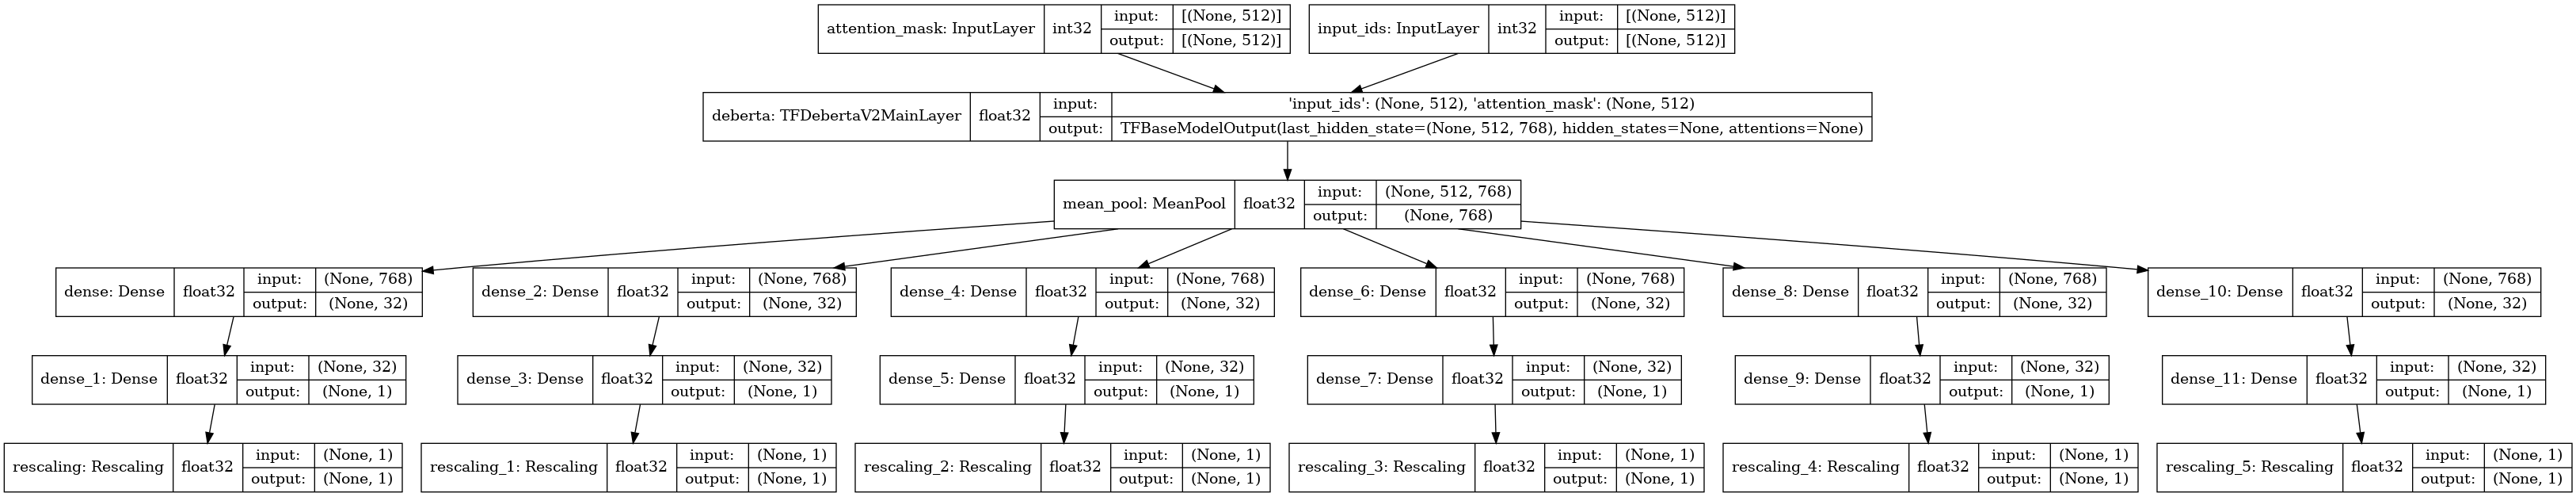

In [11]:
#Visualize Model Structure
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True)

In [12]:
#Model training
t1=datetime.datetime.now()
out = model.fit(train_dataset,validation_data=test_dataset,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,callbacks=[reduceLR,es],epochs=20,verbose=1)
print("#"*150)
print("Total time taken: ", datetime.datetime.now()-t1)

2022-11-12 16:03:03.823243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
195/195 [==============================] - 403s 2s/step - loss: 3.4788 - rescaling_loss: 0.6211 - rescaling_1_loss: 0.4775 - rescaling_2_loss: 0.4163 - rescaling_3_loss: 0.3898 - rescaling_4_loss: 0.8770 - rescaling_5_loss: 0.6970 - rescaling_mean_squared_error: 0.6211 - rescaling_1_mean_squared_error: 0.4775 - rescaling_2_mean_squared_error: 0.4163 - rescaling_3_mean_squared_error: 0.3898 - rescaling_4_mean_squared_error: 0.8770 - rescaling_5_mean_squared_error: 0.6970 - val_loss: 2.1627 - val_rescaling_loss: 0.3908 - val_rescaling_1_loss: 0.3476 - val_rescaling_2_loss: 0.2894 - val_rescaling_3_loss: 0.3267 - val_rescaling_4_loss: 0.4757 - val_rescaling_5_loss: 0.3325 - val_rescaling_mean_squared_error: 0.3908 - val_rescaling_1_mean_squared_error: 0.3476 - val_rescaling_2_mean_squared_error: 0.2894 - val_rescaling_3_mean_squared_error: 0.3267 - val_rescaling_4_mean_squared_error: 0.4757 - val_rescaling_5_mean_squared_error: 0.3325
Epoch 2/20
195/195 [=======================

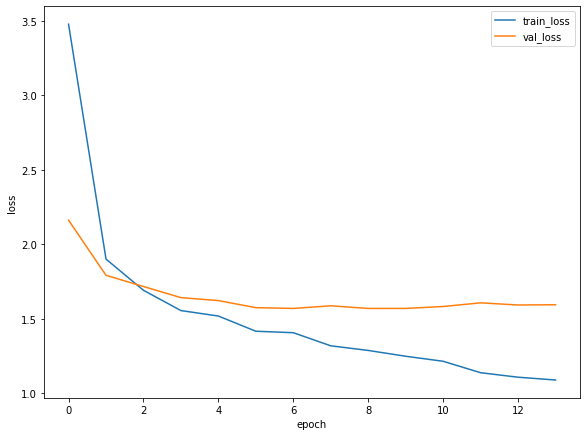

In [13]:
plt.figure(figsize=(6.4*1.5,4.8*1.5)) 
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

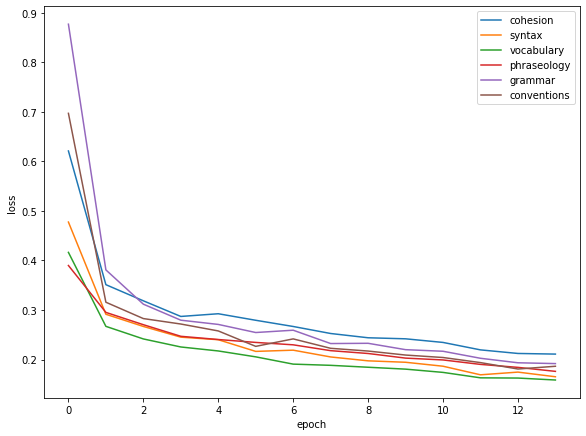

In [14]:
plt.figure(figsize=(6.4*1.5,4.8*1.5)) 
plt.plot(out.history['rescaling_loss'])
plt.plot(out.history['rescaling_1_loss'])
plt.plot(out.history['rescaling_2_loss'])
plt.plot(out.history['rescaling_3_loss'])
plt.plot(out.history['rescaling_4_loss'])
plt.plot(out.history['rescaling_5_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"])
plt.show()

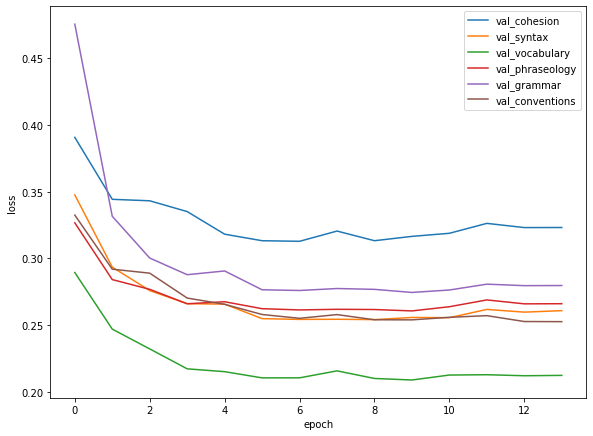

In [15]:
plt.figure(figsize=(6.4*1.5,4.8*1.5)) 
plt.plot(out.history['val_rescaling_loss'])
plt.plot(out.history['val_rescaling_1_loss'])
plt.plot(out.history['val_rescaling_2_loss'])
plt.plot(out.history['val_rescaling_3_loss'])
plt.plot(out.history['val_rescaling_4_loss'])
plt.plot(out.history['val_rescaling_5_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["val_cohesion", "val_syntax", "val_vocabulary", "val_phraseology", "val_grammar", "val_conventions"])
plt.show()

In [16]:
#Making prediction on test dataset
Y_pred = model.predict(test_dataset_wo_label)

In [17]:
_, Y1_test, Y2_test, Y3_test, Y4_test, Y5_test, Y6_test = inputfromDF(df_test)
Y_test = np.vstack([Y1_test, Y2_test, Y3_test, Y4_test, Y5_test, Y6_test]).T
Y_pred1 = np.vstack([roundoffScore(j) for j in i] for i in np.hstack([x for x in Y_pred]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
#Prediction on test data after roundoff
Y_pred1[0:5,:]

array([[3.5, 3. , 3.5, 3.5, 3.5, 3.5],
       [4. , 3.5, 3.5, 3.5, 3.5, 3.5],
       [3. , 2.5, 3. , 2.5, 2.5, 2.5],
       [3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
       [4. , 3.5, 4. , 3.5, 3.5, 4. ]])

In [19]:
#Category wise RMSE for each target after prediction roundoff
MCRMSE(Y_test, Y_pred1)

MSE for cohesion : 0.3327
MSE for syntax : 0.2708
MSE for vocabulary : 0.2369
MSE for phraseology : 0.2826
MSE for grammar : 0.3024
MSE for conventions : 0.2695


0.2824606215410813

In [20]:
#Category wise RMSE for each target prediction
print("MCRMSE without roundoff")
try:
    print(MCRMSE(Y_test, np.vstack([j for j in i] for i in np.hstack([x for x in Y_pred]))))
except:
    print("Error in MCRMSE")
    pass

MCRMSE without roundoff
MSE for cohesion : 0.3140
MSE for syntax : 0.2531
MSE for vocabulary : 0.2083
MSE for phraseology : 0.2617
MSE for grammar : 0.2780
MSE for conventions : 0.2513
0.26107360552336284


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


### Prediction on unseen data

In [21]:
Y_pred_sub = model.predict(sub_dataset)

In [22]:
Y_pred_sub1 = np.vstack([j for j in i] for i in np.hstack([x for x in Y_pred_sub]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [23]:
df_sub['cohesion'] = Y_pred_sub1[:,0]
df_sub['syntax'] = Y_pred_sub1[:,1]
df_sub['vocabulary']= Y_pred_sub1[:,2]
df_sub['phraseology']= Y_pred_sub1[:,3]
df_sub['grammar']= Y_pred_sub1[:,4]
df_sub['conventions']= Y_pred_sub1[:,5]

In [24]:
#Unseen data prediction
df_sub.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.440568,2.472119,2.889102,2.729099,2.541298,2.454349
1,000BAD50D026,Do you think students would benefit from being...,2.846240,2.467996,2.716001,2.536105,2.240240,2.531462
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.314401,3.044396,3.457524,3.483252,3.425052,3.282198


In [25]:
df_sub.drop(columns=['full_text']).to_csv("submission.csv",index=False)